# Trend Analysis
Assess how the over-time trend is related to phenotypes

In [1]:
%matplotlib notebook
import scipy
import numpy
from IPython.display import display, HTML
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import re
import matplotlib.patches as mpatches
from scipy.c0luster import hierarchy
import pylab
import pandas

In [2]:
OUTDIR = "../phewas/trends/"

In [3]:
# Original activity data
full_activity = pandas.read_csv("../processed/activity_features_aggregate.txt", index_col=0, sep="\t")
full_activity_summary = pandas.read_csv("../processed/activity_summary_aggregate.txt", index_col=0, sep="\t")

ukbb = pandas.read_hdf("../processed/ukbb_data_table.h5")

c:\users\tgb\data\ukbb\scripts\venv\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (816) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
# Load seasonal repeat data
full_activity_seasonal = pandas.read_csv("../processed/activity_features_aggregate_seasonal.txt", index_col=0, sep="\t")
id_instance = pandas.Series(full_activity_seasonal.index).astype(str).str.split(".", expand=True)
full_activity_seasonal["id"] = id_instance[0].values
full_activity_seasonal["instance"] = id_instance[1].values


full_activity_summary_seasonal = pandas.read_csv("../processed/activity_summary_aggregate_seasonal.txt", index_col=0, sep="\t")
id_instance = pandas.Series(full_activity_summary_seasonal.index).astype(str).str.split(".", expand=True)
full_activity_summary_seasonal["id"] = id_instance[0].values
full_activity_summary_seasonal["instance"] = id_instance[1].values

c:\users\tgb\data\ukbb\scripts\venv\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (816) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
# drop activity for people who fail basic QC
[c for c in full_activity_summary.columns if 'quality' in c]
okay = (full_activity_summary['quality-goodCalibration'].astype(bool)
            & (~full_activity_summary['quality-daylightSavingsCrossover'].astype(bool))
            & (full_activity_summary['quality-goodWearTime'].astype(bool))
       )
activity = full_activity_seasonal[full_activity_seasonal.index.isin(okay.index[okay])].copy()
activity_summary = full_activity_summary[okay].copy()
activity.columns = activity.columns.str.replace("-","_") # Can't use special characters easily
print(f"Dropping {(~okay).sum()} entries out of {len(okay)} due to bad quality or wear-time in their activity")

okay = (full_activity_summary_seasonal['quality-goodCalibration'].astype(bool)
            & (~full_activity_summary_seasonal['quality-daylightSavingsCrossover'].astype(bool))
            & (full_activity_summary_seasonal['quality-goodWearTime'].astype(bool))
       )
activity_seasonal = full_activity_seasonal[full_activity_seasonal.index.isin(okay.index[okay])].copy()
activity_summary_seasonal = full_activity_summary_seasonal[full_activity_summary_seasonal.index.isin(okay.index[okay])].copy()
activity_seasonal.columns = activity_seasonal.columns.str.replace("-","_") # Can't use special characters easily
print(f"Dropping {(~okay).sum()} entries out of {len(okay)} due to bad quality or wear-time in their SEASONAL activity")


Dropping 11363 entries out of 103688 due to bad quality or wear-time in their activity
Dropping 1675 entries out of 11773 due to bad quality or wear-time in their SEASONAL activity


In [7]:
## Select the activity variables that have between-person variance greater than their within-person variance
# and for the summary variables, use only those that are overall summary variables
activity_variance = pandas.read_csv("../processed/inter_intra_personal_variance.txt", sep="\t", index_col=0)
activity_variance['summary_var'] = activity_variance.index.isin(activity_summary.columns)
activity_variance['use'] = (~activity_variance.summary_var) | activity_variance.index.str.contains("overall-")
good_variance = (activity_variance.normalized < 1)
activity_variables = activity_variance.index[good_variance & activity_variance.use]
activity_variables = activity_variables.intersection(activity.columns)
activity_variables = activity_variables.str.replace("-[,:/]","_")

In [8]:
# Add the summary data
summary_columns = activity_summary.columns.intersection(activity_variance.index[activity_variance.use])
activity = activity.join(activity_summary[summary_columns])
activity.columns = activity.columns.str.replace("-[,:/]","_") # Can't use special characters easily
activity_seasonal = activity_seasonal.join(activity_summary_seasonal[summary_columns])
activity_seasonal.columns = activity_seasonal.columns.str.replace("-[,:/]","_") # Can't use special characters easily

In [9]:
print(f"Started with {len(activity.columns.intersection(activity_variance[activity_variance.use].index))} activity variables")
activity = activity[activity.columns[activity.columns.isin(activity_variables)]]
print(f"Selected {len(activity.columns)} after discarding those with poor intra-personal variance")

Started with 124 activity variables
Selected 38 after discarding those with poor intra-personal variance


In [10]:
print(f"Remaining {len(activity_seasonal.index)} entries across {len(activity_seasonal['id'].unique())} individuals")

Remaining 10096 entries across 3157 individuals


In [11]:
# Generate processed columns
# Make phase unimodal by moving it to 0-24 hours
activity_seasonal['phase'] = (activity_seasonal.phase) % 24
activity_seasonal['cosinor_log10_pvalue'] = -numpy.log10(activity_seasonal.cosinor_pvalue)
activity_seasonal.loc[~numpy.isfinite(activity_seasonal.cosinor_log10_pvalue), 'cosinor_log10_pvalue'] = float("NaN") # Drop infs

c:\users\tgb\data\ukbb\scripts\venv\lib\site-packages\pandas\core\series.py:853: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [12]:
# Add start dates
activity['start_date'] = pandas.to_datetime(activity_summary['file-startTime'])
activity_seasonal['start_date'] = pandas.to_datetime(activity_summary_seasonal.sort_index()['file-startTime'])

In [13]:
data = pandas.concat([activity_seasonal.reset_index(),
                      activity.reset_index().assign(instance=0, id=activity.index)],
                    sort=False).drop(columns=["index"])
data.id = data.id.astype(int)
data.instance = data.instance.astype(int)

<IPython.core.display.Javascript object>


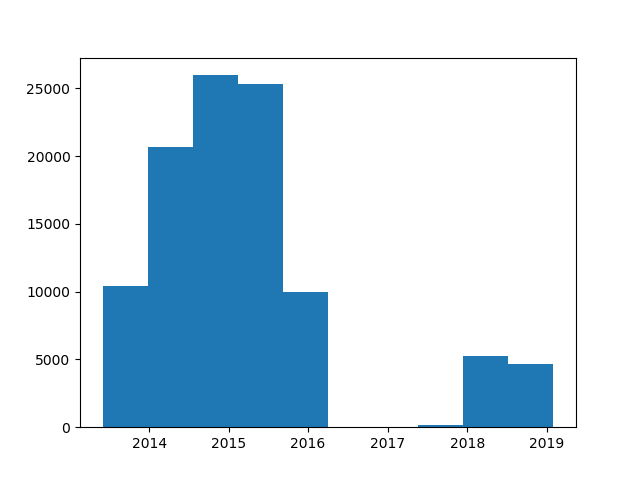

(array([10413., 20686., 25973., 25303.,  9950.,     0.,     0.,   131.,
         5277.,  4688.]),
 array([735020.41584491, 735227.41593403, 735434.41602315, 735641.41611227,
        735848.41620139, 736055.41629051, 736262.41637963, 736469.41646875,
        736676.41655787, 736883.41664699, 737090.41673611]),
 <a list of 10 Patch objects>)

In [33]:
fig, ax = pylab.subplots()
ax.hist(data.start_date)

In [15]:
start = data.sort_values(by="instance").groupby("id").first()
def get_ending(data):
    # Grab randomly one of the seasonal repeat timepoints
    # Chosen randomly so as to not have a season bias
    # and return nothing if no seasonal repeats
    selected = data[data.instance > 0]
    if len(selected) == 0:
        return pandas.DataFrame([])
    return selected.sample()
end = data.sort_values(by="instance").groupby("id").apply(get_ending)

In [16]:
start = start.reset_index().set_index("id")
end = end.drop(columns="id").reset_index().set_index("id")

In [17]:
start = start.loc[end.index]

In [18]:
trend = (end - start).divide((end.start_date - start.start_date) / pandas.to_timedelta("1Y"), axis=0)

In [19]:
trend_data = trend.join(ukbb, how="inner")

In [21]:
# Quantitative traits:
import fields_of_interest
quantitative_blocks = [
    fields_of_interest.blood_fields,
    fields_of_interest.urine,
    fields_of_interest.arterial_stiffness,
    fields_of_interest.physical_measures,
]
quantitative_vars = [c for block in quantitative_blocks
                        for c in block
                        if (c in ukbb.columns) and (pandas.api.types.is_numeric_dtype(ukbb[c].dtype))]
quantitative_vars = [c.replace("-", "_") for c in quantitative_vars]

In [22]:
# Test all associations
trend_tests = []
for quantitative_var in quantitative_vars:
    for activity_var in activity_variables:
        results = smf.ols(f"{activity_var} ~ {quantitative_var} + birth_year*sex", data=trend_data).fit()
        trend_tests.append({
            "quantitative_var": quantitative_var,
            "activity_var": activity_var,
            "pvalue": results.pvalues[quantitative_var],
            "coef": results.params[quantitative_var],
            "std_coef": results.params[quantitative_var] / trend_data[quantitative_var].std()
        })

c:\users\tgb\data\ukbb\scripts\venv\lib\site-packages\statsmodels\regression\linear_model.py:1578: RuntimeWarning: invalid value encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid
c:\users\tgb\data\ukbb\scripts\venv\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
c:\users\tgb\data\ukbb\scripts\venv\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
c:\users\tgb\data\ukbb\scripts\venv\lib\site-packages\scipy\stats\_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
c:\users\tgb\data\ukbb\scripts\venv\lib\site-packages\statsmodels\regression\linear_model.py:1578: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid
c:\users\tgb\data\ukbb\scripts\venv\lib\site-packages\s

In [24]:
trend_tests = pandas.DataFrame(trend_tests)

In [29]:
trend_tests.sort_values("pvalue").pvalue

749     0.000238
1059    0.000653
348     0.000718
1061    0.000830
2475    0.002655
          ...   
2807         NaN
2808         NaN
2809         NaN
2810         NaN
2811         NaN
Name: pvalue, Length: 3040, dtype: float64

<IPython.core.display.Javascript object>


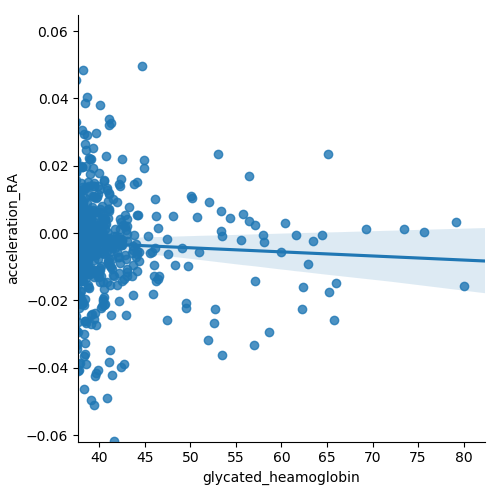

In [35]:
#fig, ax = pylab.subplots()

#ax.scatter(trend_data.glycated_heamoglobin, trend.mesor)
sns.lmplot(x="glycated_heamoglobin", y="acceleration_RA", data=trend_data)